# MIDAS Code Example


This Jupyter notebook is a quick interactive example of how to use MIDAS in practice. To this end, I will quickly reproduce the method by which we attained estimated variance of imputed values on the [Adult Census dataset](https://archive.ics.uci.edu/ml/datasets/adult).

Code right now is very hot. If you have any problems getting this demo running, it may just be I've respecified default parameters.

For now, setup must be done manually. Later versions will include pip support. Copy both midas.py and adult_data.csv into your Jupyter Notebooks directory. This is so they can be read into memory. The first thing we will do is manage imports, and import the data we will be using.  

In [1]:
from midas import Midas
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

data_0 = pd.read_csv('adult_data.csv').drop(['Unnamed: 0', 'class_labels'], axis=1)
print(data_0.head())

   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country  
0          2174             0              40  United-States  
1             0             0              13  United-St

Next, we will generate some missingness. Very few columns in the actual data contain missing values, so we want to change this. For the variance tests, we spiked in 100 values to test against. For this example, let's make this number a little larger - 5000 values in each column. We will then replace the sampled indices with np.nan...our missing value. While it is possible to sample 5000 values directly, we often used masks as they allow us to return later and inspect the error. While this notebook won't be reproducing that process, feel free to adapt the code examples. We also save one of the removed values for the end.

In [2]:
np.random.seed(441)

def spike_in_generation(data):
    spike_in = pd.DataFrame(np.zeros_like(data), columns= data.columns)
    for column in data.columns:
        subset = np.random.choice(data[column].index[data[column].notnull()],
                                     5000, replace= False)
        spike_in.loc[subset, column] = 1
    return spike_in

spike_in = spike_in_generation(data_0)
original_value = data_0.loc[4, 'hours_per_week']
data_0[spike_in == 1] = np.nan

The next task is to code the categorical variables. This is done by subsetting them out to a new dataframe, and converting them to One-Hot. We need to ensure that missing values aren't converted to zeroes yet, so we generate a temporary index to mark the location of missing entries. Finally, the encoded categorical columns are appended to a list already containing data_0 - the continuous variables. 

The utility of columns_list may not be apparent now, but it simplifies things immensely when it comes to building the MIDAS instance. If your data contains a lot of categorical data that needs conversion to One-Hot, consider implementing something similar.

In [3]:
categorical = ['workclass','education','marital_status','occupation',
               'relationship','race','sex','native_country']
data_0.columns.str.strip()
data_1 = data_0[categorical]
data_0.drop(categorical, axis= 1, inplace= True)

constructor_list = [data_0]
columns_list = []

for column in data_1.columns:
    na_temp = data_1[column].isnull()
    temp = pd.get_dummies(data_1[column])
    temp[na_temp] = np.nan
    constructor_list.append(temp)
    columns_list.append(list(temp.columns.values))

Next, we concat the dataset back into one dataframe, and apply a minmax scaler. Minmax maps the range of all values to between 0 and 1 - useful for keeping the gradients flowing through the neural network small. Smaller numbers means weight updates will have gradual change, not destructive oscillation. In some cases, having the minimum value equal to 0 does have some drawbacks, though. If your low-end values are giving you strange results, consider trying a different scaling scheme.

We used the minmax scaler on the entire dataset for convenience. Minmax won't affect OneHot variables, but other scalers might. Again, we marked the locations of the np.nan values, and were sure to replace them once we'd scaled the columns. Numpy, SkLearn and Tensorflow don't share R's 'na.rm' functionality. Instead, we have to be sure to pass in numeric values or else we'll have errors returned.

In [4]:
data_0 = pd.concat(constructor_list, axis=1)

scaler = MinMaxScaler()
na_loc = data_0.isnull()
data_0.fillna(data_0.median(), inplace= True)
data_0 = pd.DataFrame(scaler.fit_transform(data_0), columns= data_0.columns)
data_0[na_loc] = np.nan

Finally, with the data prepared, we can use MIDAS to impute the missing vlaues. The first thing we will do is instantiate MIDAS. For this test, we will build a small 2 layer, 128 units per layer, network for demonstration. The layer_structure argument defaults to mirroring the input layer structure on the output. All the hyperparameters are specified in the instantiation, and all the data is passed into the .build_model() method. As the categories we are using are mutually exclusive, we must pass these column names into the softmax_columns argument. This ensures we have error accurately measured for each category, and the loss is appropriately weighted.

In general, bigger models are better. The 'magic' of stochastic regularisation means it's generally better to have excess capacity as opposed to not enough. Feel free to experiment with larger and smaller models, but remember...bigger models can take much longer to train! Moving the layers up to 512 or 1024 leads to a noticeable increase in performance, although other hyperparameters (such as  learn_rate) need to be tuned in parallel.

In [5]:
imputer = Midas(layer_structure= [128], vae_layer= False, seed= 42)
imputer.build_model(data_0, softmax_columns= columns_list)

Size index: [6, 8, 16, 7, 14, 6, 5, 2, 41]


C:\Users\Alex\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Computation graph constructed



There are a number of additional arguments that can be passed to both the instantiation and most methods. To check what they are and recommended settings, consult the [list of MIDAS functions](https://github.com/Oracen/MIDAS/blob/master/midas_functions.md). Alternatively, just use the ?? command on any method to display the help text. Using the help command on the class itself will bring up the entire source code, so if you're not used to coding in Python, the commands you're looking for are found under "init". 

In [ ]:
??Midas.generate_samples()

In [ ]:
??Midas

First, we want to make sure our model is building an accurate representation of the data. The first method we should call is .overimpute(). This method removes a set proportion of known values, and allows us to explore the evolution of the model's output. It is a way of estimating the ideal model complexity which will give us the most accurate imputations - the values become our out-of-sample data. We do not want to do this during the actual run, though. Not only does a train-test split setup overestimate ideal model complexity in autoencoders, but it denies the model anywhere between 10% and 30% of existing data. At higher levels of missingness, this additional data could be crucial.

In general, we want to see both cost and out-of-sample error constantly decreasing. In practice, too much capacity and too much training may cause error to rise again. This is called overtraining, and it is to be avoided. If clear overtraining appears while running .overimpute(), ensure that the 'training_epochs' argument of .train_model() is set to end training before this point.


Model initialised

Epoch: 0 , loss: 9.146274960369144
Individual RMSE on spike-in: 0.14973735121121862
Aggregated RMSE on spike-in: 0.13325244251735754
Individual error on softmax spike-in: 0.3791861313433623
Aggregated error on softmax spike-in: 0.35759630384526253


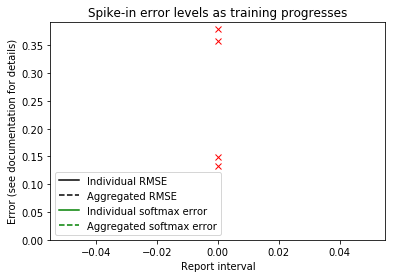

Epoch: 1 , loss: 4.8757237953720995
Individual RMSE on spike-in: 0.14040044078960373
Aggregated RMSE on spike-in: 0.13122452436842208
Individual error on softmax spike-in: 0.37610116987375697
Aggregated error on softmax spike-in: 0.3387286990942075


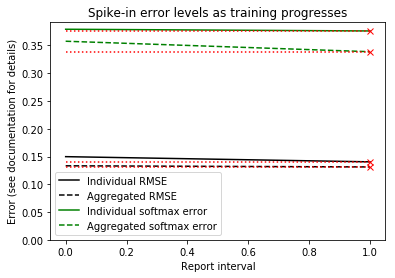

Epoch: 2 , loss: 3.688461220592534
Individual RMSE on spike-in: 0.1380641065083043
Aggregated RMSE on spike-in: 0.13074003831443132
Individual error on softmax spike-in: 0.3747911149955451
Aggregated error on softmax spike-in: 0.33482970869869066


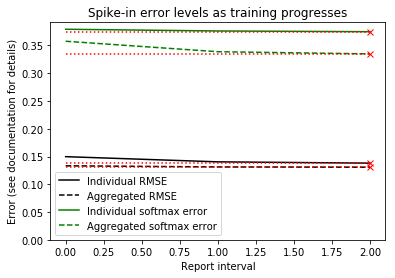

Epoch: 3 , loss: 3.2290964106276028
Individual RMSE on spike-in: 0.1368668985562118
Aggregated RMSE on spike-in: 0.13063060511520883
Individual error on softmax spike-in: 0.37597623480350695
Aggregated error on softmax spike-in: 0.333506873408847


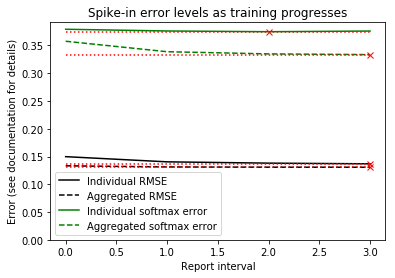

Epoch: 4 , loss: 2.9963561315211527
Individual RMSE on spike-in: 0.13630240786695413
Aggregated RMSE on spike-in: 0.1307396420649981
Individual error on softmax spike-in: 0.3768615986535913
Aggregated error on softmax spike-in: 0.33320248110155204


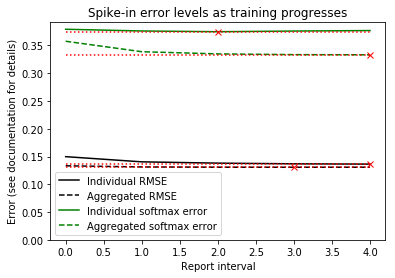

Epoch: 5 , loss: 2.8919766540217995
Individual RMSE on spike-in: 0.1362811595626995
Aggregated RMSE on spike-in: 0.13092404702519977
Individual error on softmax spike-in: 0.37424643012759246
Aggregated error on softmax spike-in: 0.33147757102649744


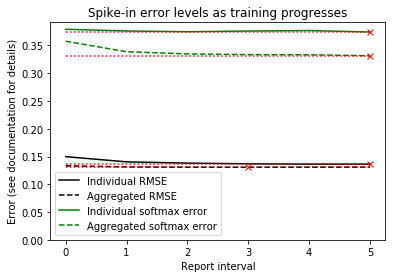

Epoch: 6 , loss: 2.8176732524584973
Individual RMSE on spike-in: 0.13552728567949293
Aggregated RMSE on spike-in: 0.13035150332865256
Individual error on softmax spike-in: 0.3752239914165529
Aggregated error on softmax spike-in: 0.3315137005810031


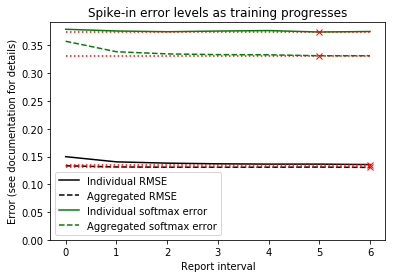

Epoch: 7 , loss: 2.764931593036589
Individual RMSE on spike-in: 0.1356659992534215
Aggregated RMSE on spike-in: 0.13024356952193147
Individual error on softmax spike-in: 0.37586095535421016
Aggregated error on softmax spike-in: 0.32992997468230656


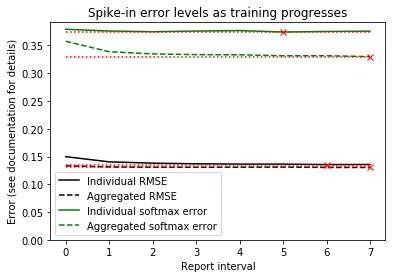

Epoch: 8 , loss: 2.731969615695986
Individual RMSE on spike-in: 0.13551167998112207
Aggregated RMSE on spike-in: 0.1303962982586063
Individual error on softmax spike-in: 0.3748493406029879
Aggregated error on softmax spike-in: 0.3304155430335382


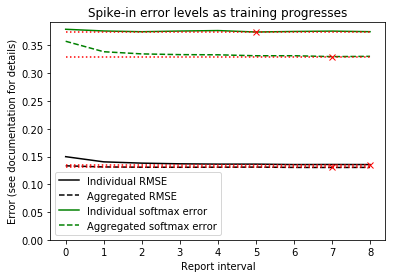

Epoch: 9 , loss: 2.695534042066859
Individual RMSE on spike-in: 0.13518972013877328
Aggregated RMSE on spike-in: 0.12977657656602132
Individual error on softmax spike-in: 0.37331204162523574
Aggregated error on softmax spike-in: 0.32941705992090786


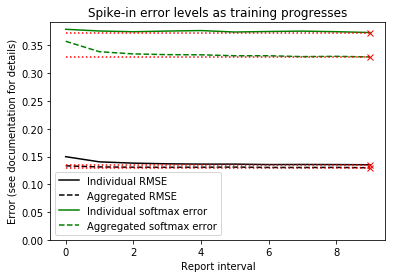

Epoch: 10 , loss: 2.688878723533719
Individual RMSE on spike-in: 0.13508392244643258
Aggregated RMSE on spike-in: 0.12982427763373908
Individual error on softmax spike-in: 0.37518456859890825
Aggregated error on softmax spike-in: 0.32979029045359937


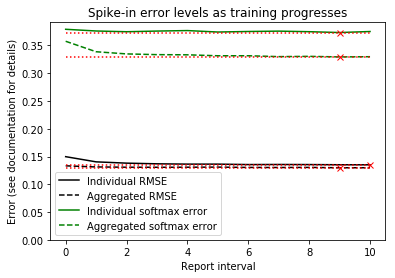

Overimputation complete. Adjust complexity as needed.


In [6]:
imputer.overimpute(training_epochs= 10, report_ival= 1,
                   report_samples= 5, plot_all= False)

5 epochs seemed to be a reasonable number. In reality, had we run the algorithm longer, we probably would have attained better results. In fact, in practice we want to run overimputation for as long as time will allow, to ensure we are getting the most accurate possible results. Still, 5 epochs will will serve for the purposes of this demo.

We run the .train_model() method, with printouts every epoch to ensure training is progressing as expected. With longer training times, increasing the interval between loss reports is a good way to remove clutter from your output.

In [7]:
imputer.train_model(training_epochs= 5, verbosity_ival= 1)

Model initialised

Epoch: 0 , loss: 9.108674546213013
Epoch: 1 , loss: 4.911678810888318
Epoch: 2 , loss: 3.754161190041396
Epoch: 3 , loss: 3.266096529024769
Epoch: 4 , loss: 3.045797487776995
Training complete. Saving file...
Model saved in file: tmp/MIDAS


Now the model is trained, we can use the saved model to generate as many imputations as we need. We generate 20 samples, which will be saved to the .output_list attribute. We then recall the value we saved right at the very start of the demo, and from each dataset extract the value for the same observation as well as its mean. Of course, now that the model is saved, we don't need to retrain the model should we return to this result.

In [8]:
imputer.batch_generate_samples(m= 5)

print("Original value:", original_value)
imputed_vals = []
for dataset in imputer.output_list:
    imputed_vals.append(pd.DataFrame(scaler.inverse_transform(dataset),
                                     columns= dataset.columns).loc[4, 'hours_per_week'])
print("Imputed values:")
print(imputed_vals)
print("Imputation mean:", np.mean(imputed_vals))
print("Standard deviation of the imputation mean:", np.std(imputed_vals))

INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.
Original value: 40
Imputed values:
[38.210144877433784, 35.98491287231446, 36.46222227811814, 36.38001829385758, 36.45068287849427]
Imputation mean: 36.697596240043644
Standard deviation of the imputation mean: 0.7762659112799503


Code-wise, that's it! You may notice the imputation mean is not perfectly accurate, with a low variance. This is a known limitation of variational inference methods, and we're currently working on implementing solutions that will improve the match between true and estimated data. In general; MIDAS currently underestimates the marginal posterior density. Unfortunately, this flows out of the maths of KL(Q||P) underlying Gal's Bayesian interpretation of dropout. That being the case, methods for improving variational estimates within deep learning are constantly improving.

This short demonstration has illustrated the main steps in using MIDAS. I hope it helps you with your own missing data challenges.